勾配降下法でポリタンクを探す
===
---

#### 参考URL
- [地理院タイル一覧](http://maps.gsi.go.jp/development/ichiran.html)
- [タイル座標確認ページ](http://maps.gsi.go.jp/development/tileCoordCheck.html)
- [地理院タイル仕様](http://maps.gsi.go.jp/development/siyou.html)
- [標高タイルの詳細仕様](http://maps.gsi.go.jp/development/demtile.html)

## 1. 準備
### 1.1. import

In [191]:
import sys
sys.path.append('..')

from geo_util import MapTile  # 地理院タイルを扱いやすくするために作った
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize

### 1.2. 関係する範囲の地理院タイルをダウンロード
できるだけ細かく取得したい。
dem5aがベストらしい。
http://maps.gsi.go.jp/help/pdf/demapi.pdf

In [29]:
from_tile, to_tile = [15, 29044, 12928], [15, 29051, 12935]
nabewari_tile = MapTile(from_tile, to_tile, zoom=15, tile_type="dem5a", ext="txt")

In [36]:
nabewari_map = MapTile([13, 7261, 3232], [13, 7262, 3233], zoom=13, tile_type="std", ext="png")

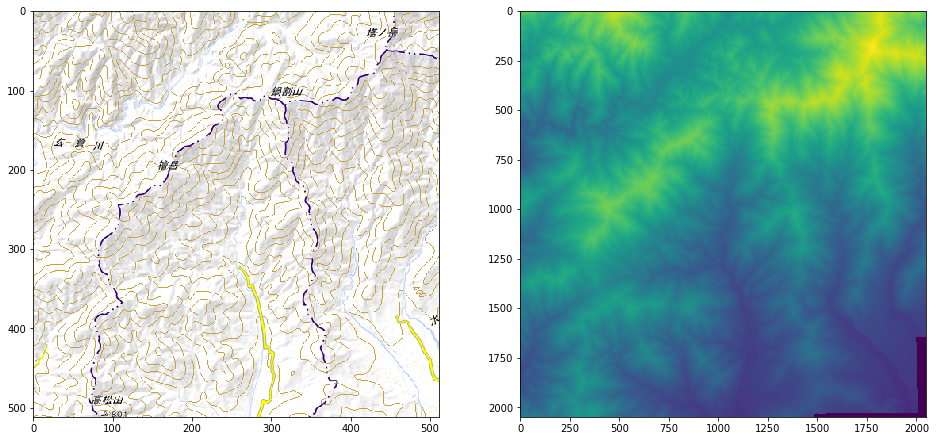

In [43]:
figsize(16, 8)
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(nabewari_map.data)
axarr[1].imshow(nabewari_tile.data, interpolation="none")

### 1.3. ポリタンクを落とした地点の座標を取得
現場の写真のExifより、以下の地点で落としたことが分かっている。

In [17]:
start_lat, start_lon = 35.437, 139.141

### 1.4. 緯度経度をピクセル座標に変換
参考：http://www.trail-note.net/tech/coordinate/

In [44]:
def latlon_to_pixel(lat, lon, zoom):
    L = 85.05112878
    x = 2**(zoom+7) * (1 + lon/180.)
    y = 2**(zoom+7) / np.pi * (- np.arctanh(np.sin(np.pi*lat/180.)) + np.arctanh(np.sin(np.pi*L/180.)))
    return x, y

In [45]:
start_x, start_y = latlon_to_pixel(start_lat, start_lon, 15)
print(start_x, start_y)

7436524.293688889 3310245.05259


これをダウンロードしてきた地理院タイル（`nabewari_tile`）のindexに変換する。

普通なら256で割った余りを取れば良いが、`nabewari_tile`は複数の地理院タイルを結合したものであることに注意する。

In [50]:
start_x = start_x - 256*from_tile[1]
start_y = start_y - 256*from_tile[2]
print(start_x, start_y)

1260.2936888886616 677.05258863


- indexに変換できたので、地図と合わせてプロットする。

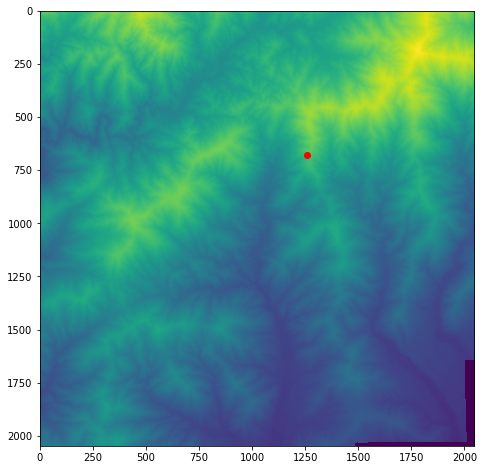

In [52]:
plt.imshow(nabewari_tile.data)
plt.scatter(x, y, color="red")

-> ちゃんと適切に計算できている（目視確認）

## 2. 勾配降下法
<img src="gradient_descent.png" width="600"></img>
画像：[Goh, "Why Momentum Really Works", Distill, 2017.](https://distill.pub/2017/momentum/)

### 2.1. 原理

初期地点を$(x_0, y_0)$として、以下のように勾配（偏微分）に基づいて移動を行う。$\epsilon$は1ステップごとの移動量を決めるパラメータである。
$$
\begin{align}
x_{k+1} = x_{k} - \epsilon \frac{\partial z}{\partial x} \\
y_{k+1} = y_{k} - \epsilon \frac{\partial z}{\partial y}
\end{align}
$$

### 2.2. 勾配の計算方法
地理院タイルでは格子点上の標高が記されている（下図の正方形の頂点）。その隙間を含む任意の地点$(x, y)$での勾配を知りたいので、下図の右下のように各格子を2つの三角形（上から見ると直角二等辺三角形に見える）に分割し、その平面の方程式を通して勾配を計算する。
<img src="../fig/grad.png", width=300></img>

(1) 点$(x, y)$が$(x-[x])+(y-[y]) < 1$を満たす（図の灰色の三角形に属する）とき:

   3点 $([x],\: [y],\: z_0),\: ([x]+1,\: [y],\: z_1),\: ([x],\: [y]+1,\: z_2)$ を通る平面の方程式を求め、$\frac{\partial z}{\partial x},\:\frac{\partial z}{\partial y}$を計算すると

$$
\frac{\partial z}{\partial x} = z_1 - z_0, \: \: \frac{\partial z}{\partial y} = z_2 - z_0
$$


(2) 点$(x, y)$が$(x-[x])+(y-[y]) \geq 1$を満たす（図の水色の三角形に属する）とき:

   3点 $([x]+1,\: [y]+1,\: z_3),\: ([x]+1,\: [y],\: z_1),\: ([x],\: [y]+1,\: z_2)$ を通る平面の方程式を求め、$\frac{\partial z}{\partial x},\:\frac{\partial z}{\partial y}$を計算すると

$$
\frac{\partial z}{\partial x} = z_3 - z_2, \: \: \frac{\partial z}{\partial y} = z_3 - z_1
$$

(1), (2)いずれの場合でも、勾配は隣の格子点同士の高さを単純に引き算したものになっている。

### 2.3. 勾配降下法の実装
クラスを作成する。停止条件やepsilonは変更可能なパラメータだが、真の値は分からないので、後ほど様々な値をセットする。

TODO: 方向転換・ランダムな停止・モメンタム

In [98]:
class TankTrajectory():
    """ 初期位置と標高タイルとパラメータを指定して勾配降下法を実行するクラス
    Input:
        start: 転がり始める地点のピクセル座標のタプル（標高タイルのindexと対応させておく）
        maptile: 勾配降下法を実行する標高タイル
        epsilon: 1stepごとの位置の更新量に影響するパラメータ
        stop_vel: タンクが停止する速度
        max_step: 最大ステップ
    Attribute: .run()を実行すると、以下の属性に値がセットされる
        .x_list: 軌道の各stepにおけるx座標のリスト
        .y_list: 軌道の各stepにおけるy座標のリスト
        .end_x: 軌道の終点におけるx座標
        .end_y: 軌道の終点におけるy座標
    """
    
    def __init__(self, start, maptile, epsilon, stop_vel, max_step):
        """ Constructor """
        self.start_x, self.start_y = start
        self.maptile = maptile
        self.epsilon = epsilon
        self.stop_vel = stop_vel
        self.max_step = max_step

    def run(self):
        """ 勾配降下法を実行 """
        x, y = self.start_x, self.start_y
        self.x_list = [x]
        self.y_list = [y]

        for step in range(self.max_step):
            try:
                gx, gy = self.maptile.grad(x, y)
            except IndexError: # タイルからはみ出した
                break
            #  勾配降下法
            x = x - self.epsilon * gx
            y = y - self.epsilon * gy
            #  軌道を保存
            self.x_list.append(x)
            self.y_list.append(y)
            # 停止判定
            if self.is_stopped():
                break

        print("stopped at step={}".format(step))
        # 停止時の座標
        self.end_x = x
        self.end_y = y

    def is_stopped(self):
        """ 停止判定 """
        if len(self.x_list) < 2:
            # 初期状態
            return False
        else:
            dx = self.x_list[-1] - self.x_list[-2]
            dy = self.y_list[-1] - self.y_list[-2]
            vel = np.sqrt(dx**2 + dy**2)
            return vel < self.stop_vel

- 使ってみる

In [106]:
t1 = TankTrajectory((start_x, start_y), nabewari_tile, epsilon=0.1, stop_vel=0.01, max_step=100000)
t1.run()

- 実行結果を可視化してみる

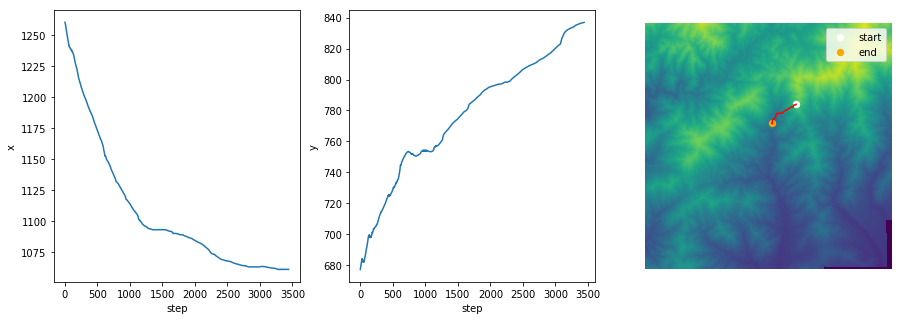

In [120]:
figsize(15, 5)
f, axarr = plt.subplots(1, 3)

# xの推移
axarr[0].plot(t1.x_list)
axarr[0].set_xlabel("step")
axarr[0].set_ylabel("x")
# yの推移
axarr[1].plot(t1.y_list)
axarr[1].set_xlabel("step")
axarr[1].set_ylabel("y")
# 軌道をプロット
axarr[2].axis("off")
axarr[2].plot(t1.x_list, t1.y_list, color="red")
axarr[2].scatter(t1.start_x, t1.start_y, color="white", s=40, label="start")
axarr[2].scatter(t1.end_x, t1.end_y, color="orange", s=40, label="end")
axarr[2].legend()
axarr[2].imshow(nabewari_tile.data)

## 3. ランダムな初期位置の生成
勾配降下法を実行する準備が整ったので、これを

- 様々な初期位置（GPSの誤差などの不確実性があるので）
- 様々なパラメータ（真の値はよく分からないので）

で実行していくことになる。まずは様々な初期位置を生成する。

ポリタンクを落とした位置の推定座標をピークとしてもつ対称な二次元正規分布をベースとするが、ポリタンクが西側に転がったことは既知なので、東側に転がってしまうような初期位置は除外する。

In [189]:
start_x_list = np.random.normal(loc=start_x, scale=10, size=100)
start_y_list = np.random.normal(loc=start_y, scale=10, size=100)
start_list = np.c_[start_x_list, start_y_list]

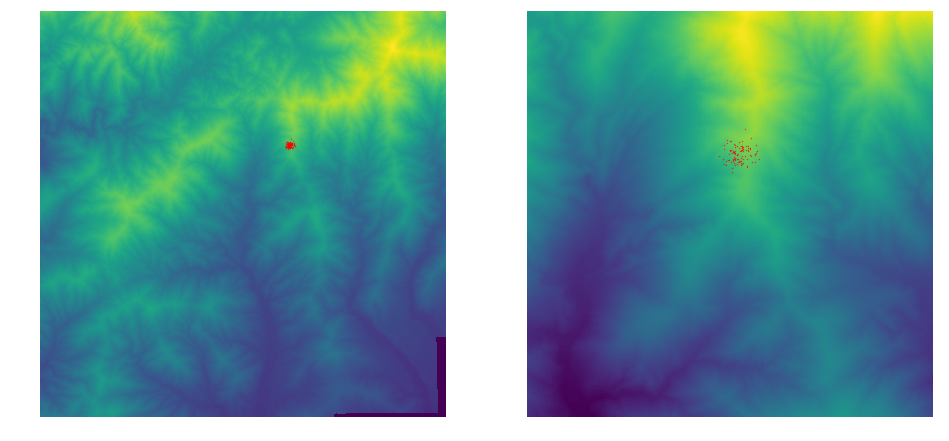

In [190]:
figsize(16, 8)
f, axarr = plt.subplots(1, 2)
axarr[0].axis("off")
axarr[1].axis("off")
axarr[0].imshow(nabewari_tile.data)
axarr[0].scatter(start_list[:, 0], start_list[:, 1], s=0.1, color="red")
axarr[1].imshow(nabewari_tile.data[500:1000, 1000:1500])
axarr[1].scatter(start_list[:, 0]-1000, start_list[:, 1]-500, s=0.1, color="red")

## 4. 様々なパラメータ・初期値で勾配降下法を実行

In [192]:
trajectory_list = []
for sx, sy in tqdm(start_list):
    trajectory = TankTrajectory((sx, sy), nabewari_tile, epsilon=0.1, stop_vel=0.01, max_step=100000)
    trajectory.run()
    trajectory_list.append(trajectory)

HBox(children=(IntProgress(value=0), HTML(value='')))

stopped at step=3361
stopped at step=3443
stopped at step=3445
stopped at step=3423
stopped at step=99999
stopped at step=99999
stopped at step=3452
stopped at step=3418
stopped at step=3384
stopped at step=99999
stopped at step=99999
stopped at step=3462
stopped at step=3403
stopped at step=3416
stopped at step=3412
stopped at step=3402
stopped at step=3458
stopped at step=3421
stopped at step=3409
stopped at step=3405
stopped at step=3421
stopped at step=3451
stopped at step=3409
stopped at step=3416
stopped at step=3432
stopped at step=3427
stopped at step=99999
stopped at step=99999
stopped at step=3440
stopped at step=3424
stopped at step=3475
stopped at step=3421
stopped at step=4146
stopped at step=3425
stopped at step=3461
stopped at step=3457
stopped at step=3436
stopped at step=3464
stopped at step=3382
stopped at step=3409
stopped at step=99999
stopped at step=99999
stopped at step=3419
stopped at step=3418
stopped at step=3407
stopped at step=3421
stopped at step=3419
stopp

In [180]:
len(trajectory_list)

1000

In [183]:
end_list = np.array([(t.end_x, t.end_y) for t in trajectory_list])
end_list

array([[ 1060.95341493,   837.06953246],
       [ 1060.95200157,   837.07067111],
       [ 1060.95304121,   837.0697255 ],
       ..., 
       [ 1376.1627852 ,   776.77923897],
       [ 1060.97450199,   837.0359327 ],
       [ 1060.95358973,   837.06951069]])

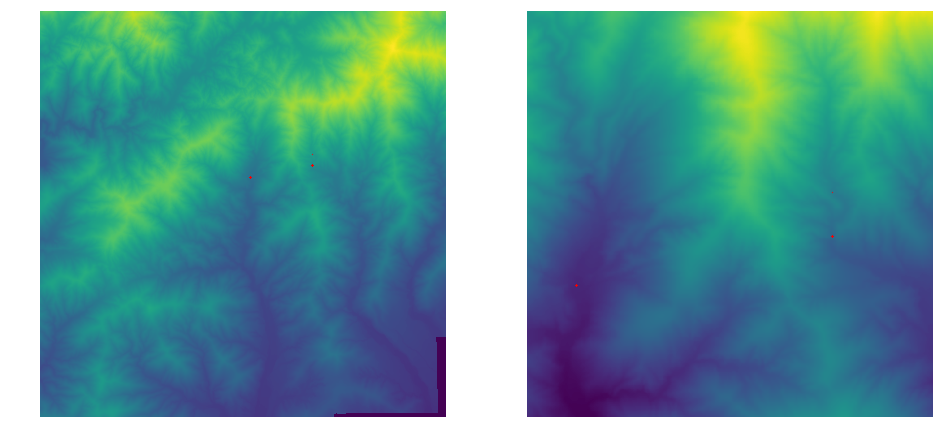

In [186]:
figsize(16, 8)
f, axarr = plt.subplots(1, 2)
axarr[0].axis("off")
axarr[1].axis("off")
axarr[0].imshow(nabewari_tile.data)
axarr[0].scatter(end_list[:, 0], end_list[:, 1], s=0.1, color="red")
axarr[1].imshow(nabewari_tile.data[500:1000, 1000:1500])
axarr[1].scatter(end_list[:, 0]-1000, end_list[:, 1]-500, s=0.1, color="red")

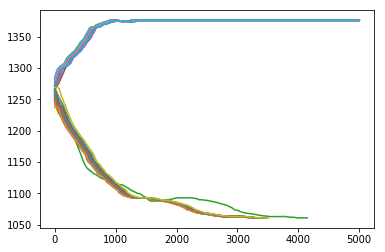

In [197]:
for t in trajectory_list:
    plt.plot(t.x_list[:5000])

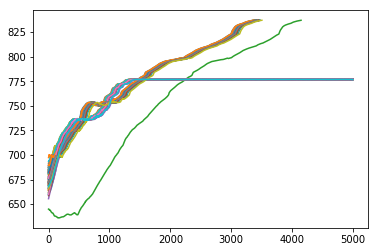

In [200]:
for t in trajectory_list:
    plt.plot(t.y_list[:5000])